# Coverage for a binomial test:
## Clopper--Pearson vs Gaussian approximation

We want to check for coverage in case of confidence intervals for a binomial test.



In [1]:
import os                                                                                                                                                                                       
import sys                                                                                                                                                                                      
import numpy as np                                                                                                                                                                              
import scipy.stats as ss                                                                                                                                                                        
import matplotlib.pyplot as plt                                                                                                                                                                 
from math import sqrt                                                                                                                                                                           
#from statsmodels.stats.proportion import proportion_confint                                                                                                                                     
from itertools import zip_longest                                                                                                                                                               
from scipy.optimize import bisect, root                                                                                                                                                         
                      
                         
# Functions in python and in R
# R qxxx = python .ppf()                                                                                                                                                                       
# R pxxx = python .cdf()                                                                                                                                                                       
# R dxxx = python .pmf()/.pdf() (I think)                                                                                                                                                             
                         

First we define the function that computes coverage in the Gaussian approximation

In [2]:
                                                                                                                                                                                               
def cover_gauss(p,n,conf_level):                                                                                                                                                                             
    if not (0 <= p and p <= 1):                                                                                                                                                                 
        sys.exit()                                                                                                                                                                              
    x = np.array(range(0, n))                                                                                                                                                                   
    fpx = ss.binom.pmf(x, n, p)                                                                                                                                                                 
    phat = x / n                                                                                                                                                                                
    crit_val = ss.norm.ppf((1 + conf_level) / 2)                                                                                                                                                
    low = [iphat - crit_val * sqrt(iphat * (1 - iphat) / n) for iphat in phat]                                                                                                                  
    hig = [iphat + crit_val * sqrt(iphat * (1 - iphat) / n) for iphat in phat]                                                                                                                  
    inies = [ int(ilow <= p and p <= ihig) for ilow, ihig in zip_longest(low, hig) ] 
    return sum(inies * fpx)                                                                                                                                                                     

# Let's just test it
print(cover_gauss(0.6, 100, 0.95))                                                                                                                                                                         
               

0.9481179791264716


...and the one that computes coverage with the Clopper-Pearson intervals

In [3]:
def cover_clopper(p, n, conf_level):                                                                                                                                                                                                                                   
    if not (0 <= p and p <= 1):                                                                                                                                                                                                                         
        sys.exit()                                                                                                                                                                                                                                      
    x = np.array(range(0, n))                                                                                                                                                                                                                         
    fpx = ss.binom.pmf(x, n, p)                                                                                                                                                                                                                                                                                                                                                                                                                           
    #print(proportion_confint(np.array(range(0,n)), n, alpha=conf_level, method="beta"))
    # Initially I did this, horribly not working
    #low = [ ss.beta.ppf(conf_level/2, ix, n-ix +1) for ix in x]                                                                                                                                                                                        
    #hig = [ ss.beta.ppf(1-conf_level/2, ix+1, n-ix) for ix in x]                                                                                                                                                                                       

    # This is the correct way, mimicking the R code below
    # although it still has issues at large p
    #low = [ (ss.beta.ppf((1-conf_level)/2., ix, n-ix+1)   )  if ix != 0 else 0 for ix in x]                                                                                                                                                              
    #hig = [ (ss.beta.isf((1-conf_level/2.), ix+1, n-ix ))  if ix != n else 1 for ix in x]                                                                                                                                                              
    low = [ (ss.beta.ppf((1-conf_level)/2., ix, n-ix+1)   )  if ix != 0 else 0 for ix in x]                                                                                                                                                              
    hig = [ (ss.beta.ppf(1-(1-conf_level)/2., ix+1, n-ix ))  if ix != n else 1 for ix in x]                                                                                                                                                              

    inies = [ int(ilow <= p and p <= ihig) for ilow, ihig in zip_longest(low, hig) ]                                                                                                                                                                                                                                                                                                                                                                                                        
    return sum(inies * fpx)                                                                                                                                                                                                                             
                           
# Let's test it
print(cover_clopper(0.98, 100, 0.95))

0.851896803463454


OK, now produce the coverage plot

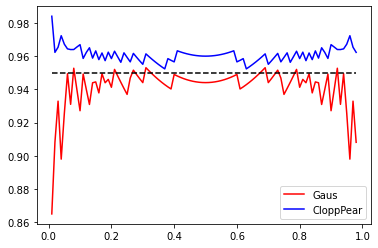

In [5]:
p= np.array(np.arange(0.01, 0.99, 0.01)) 
n=200                                                                                                                                                                                         
clevel=0.95                                                                                                                                                                                 
       
    
fix, ax = plt.subplots(1,1)                                                                                                                                                                                                                                                                                                                                                                                                                                                  
plt.plot(p, [ cover_gauss(ip, n, clevel) for ip in p], color="red", label='Gaus', linestyle="solid")                                                                                                                                                                             
plt.plot(p, [ cover_clopper(ip, n, clevel) for ip in p], color="blue", label='CloppPear', linestyle="solid")                                                                                                                                                                          
plt.plot(p, [ clevel for ip in p ], color="black", linestyle="dashed")                    
plt.legend(loc='best')
plt.show()  

Now you should play with different values for $n$.

It turns out that for low values ($\sim<150$) the coverage at high p drops below the nominal, which should instead guaranteed to not happen.

If you have R installed in your system, you can now run the notebook [coverageTestBinomial_R.ipynb](coverageTestBinomial_R.ipynb).

The notebook shows that an analogous implementation in R does not exhibit the same problem. I suspect the issue might be due to return values for the pmf of the binomial in the python implementation, but haven't debugged this.

To be able to run R code within jupyter, you must have installed the package `IRkernel` in your R installation (either with `IRkernel::installspec()` or with `install.packages("IRkernel")`, or via your distribution. NOT in RStudio.